In [102]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [103]:
# Load your data
data = pd.read_csv('datapreprocessing.csv')

# Assuming 'ingredients' column is text and the skin types columns are 'combination', 'dry', etc.
mlb = MultiLabelBinarizer()

labels = []
for _, row in data[['combination', 'dry', 'normal', 'oily', 'sensitive']].iterrows():
    labels.append(row.index[row == 1].tolist())

y = mlb.fit_transform(labels)
print("Target shape (y):", y.shape)  # Should output (num_samples, 5)

# Check the encoding result
print(mlb.classes_)
print(y[:5])  # Preview the first 5 labels

Target shape (y): (903, 5)
['combination' 'dry' 'normal' 'oily' 'sensitive']
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [104]:
# Tokenizer for the ingredients column
tokenizer = Tokenizer(num_words=5000)  # Limit the number of words to 5000
tokenizer.fit_on_texts(data['ingredients'])

# Convert sentences to sequences of integers
X = tokenizer.texts_to_sequences(data['ingredients'])

# Pad sequences to ensure consistent input size
X = pad_sequences(X, padding='post', maxlen=100)

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [112]:
def create_model(vocab_size, embedding_dim, max_length):
  model = models.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

  return model

In [113]:
vocab_size = 2500
embedding_dim = 64
max_length = 50

model = create_model(vocab_size, embedding_dim, max_length)
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [108]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [114]:
epochs = 50
batch_size = 32

# history = model.fit(X_train, y_train, epochs, batch_size, validation_data=(X_val, y_val))
history = model.fit(X_train, y_train, epochs, batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.3219 - loss: 0.6478 - val_accuracy: 0.0111 - val_loss: 0.4120
Epoch 2/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.1321 - loss: 0.3704 - val_accuracy: 0.9668 - val_loss: 0.3192
Epoch 3/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9707 - loss: 0.3162 - val_accuracy: 0.9668 - val_loss: 0.3055
Epoch 4/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.9689 - loss: 0.3020 - val_accuracy: 0.9668 - val_loss: 0.3040
Epoch 5/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9741 - loss: 0.3047 - val_accuracy: 0.9668 - val_loss: 0.3025
Epoch 6/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9776 - loss: 0.3035 - val_accuracy: 0.9668 - val_loss: 0.3036
Epoch 7/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9793 - loss: 0.2672 - val_accuracy: 0.9668 - val_loss: 0.3038
Epoch 8/32
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9739 - loss: 0.3100 - val_accuracy: 0.

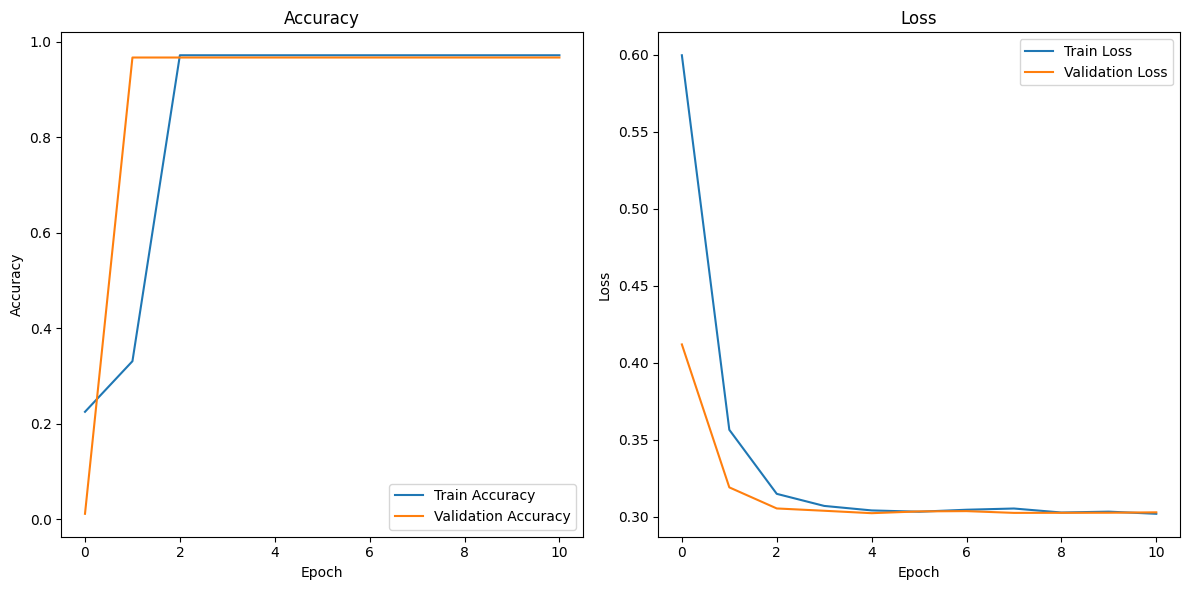

In [115]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [134]:
import numpy as np
def predict_skin_type(ingredient_text):
    # Tokenize and pad the input
    seq = tokenizer.texts_to_sequences([ingredient_text])
    padded = pad_sequences(seq, padding='post', maxlen=100)

    # Predict the probabilities for each skin type
    pred = model.predict(padded)

    # Use argmax to find the skin types with the highest probabilities
    predicted_types = mlb.classes_[np.argmax(pred, axis=1)]

    return predicted_types

In [135]:
# Example prediction
ingredient_example = "water, ethylhexyl methoxycinnamate, butyl methoxydibenzoylmethane, stearic acid, peg 100 stearate, glyceryl stearate, dicaprylyl carbonate, cyclopentasiloxane, cetyl alcohol, glycerin, niacinamide, aloe barbadensis leaf extract, 1,3 butylene glycol, titanium dioxide, xylitylglucoside, anhydroxylitol, xylitol, ammonium acryloyldimethyltaurate/ carboxyethyl acrylate crosspolymer, alpha arbutin, caprylic/capric triglyceride, helianthus annuus (sunflower) seed oil, dimethicone, phenoxyethanol, triethylene glycol, avena strigosa seed extract, allantoin, fragrance, tocopherol, disodium edta, potassium hydroxide"
predicted_skin_types = predict_skin_type(ingredient_example)
print(predicted_skin_types)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['combination']


In [123]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9759 - loss: 0.2991
Validation Loss: 0.3024576008319855
Validation Accuracy: 0.9667896628379822


In [132]:
model.save('model.h5')

In [131]:
# TFLITE

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable resource variables if needed
converter.experimental_enable_resource_variables = True

# Enable Flex Ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use built-in ops
    tf.lite.OpsSet.SELECT_TF_OPS    # Enable TensorFlow Select ops (Flex ops)
]

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Perform conversion
tflite_model = converter.convert()

# Save the model
tflite_file_path = 'model_with_flex_ops.tflite'
with open(tflite_file_path, 'wb') as f:
    f.write(tflite_model)

print(f'Model has been saved to {tflite_file_path}')

Saved artifact at '/tmp/tmptzxq87t5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor_98')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139858599547072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858375867760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858374224784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858374220384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858374221616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858376606640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858591516272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858591524720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858592077376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858592076672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139858592080720: Te